## Detección de Pishing - Laboratorio 01

Sara Zavala  18893   
Alexa Bravo  18831  

In [1]:
#Se importan las librerias que vamos a utilizar.
import  numpy as np
import  re
import pandas as pd
import  matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import pandas_profiling as pp
from pandas_profiling import ProfileReport
import sklearn
from sklearn import metrics, model_selection, tree

### Parte 1 – Ingeniería de características

#### Exploración de datos 

In [2]:
#Cargamos los datos.
df = pd.read_csv('dataset_pishing.csv')
df.head(5)

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,0,0,0,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [3]:
#Cantidad de datos en la columna status. 
df.status.value_counts()

phishing      5715
legitimate    5715
Name: status, dtype: int64

Se puede observar que el dataset esta balanceado ya que tiene la columna "status" cuenta con la misma cantidad de datos en la variable "legitimate" como en la variable "phishing".  

#### Derivación de características 

In [4]:
#f1 longitud del url. 
df['f1'] = df['url'].str.len()

In [5]:
#Función para obtener la longitud del hostname. 
def Hostname(s):
    return urlparse(s).hostname

#f2: Longitud del hostname.
df['f2'] = df['url'].apply(Hostname).str.len()

In [6]:
#Función para verificar que el url tenga "https"
def Https(s):
    return 1 if urlparse(s).scheme == 'https' else 0

#f25: HTTPS 
df['f25'] = df['url'].apply(Https)

In [7]:
#f26: Proporción de digitos en la URL.
df['f26'] = df['url'].str.count('[0-9]')/df['f1']

In [8]:
#f27: Proporción de digitos en el hostname.
df['f27'] = df['url'].apply(Hostname).str.count('[0-9]')/df['f2']

In [9]:
#f4-20: Caracteres especiales. 
def specialChars(direction):
    i = 0
    for x in direction:
        if "-" in x or "." in x or "@" in x or "?" in x or "&" in x or "|" in x or "=" in x or "_" in x or "~" in x or "%" in x or "/" in x or " " in x or ":" in x or "," in x or ";" in x or "$" in x or "%20" in x:
            i += 1
    return i

In [10]:
#f4-20: Caracteres especiales. 
#specialChars('.-?####ajsdfhjkadsf @')
df['f4-20'] = df['url'].apply(specialChars)

In [11]:
#Dataset con las columnas nuevas. 
df.head(5)

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,dns_record,google_index,page_rank,status,f1,f2,f25,f26,f27,f4-20
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,1,1,4,legitimate,37,19,0,0.000000,0.0,7
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,0,1,2,phishing,77,23,0,0.220779,0.0,7
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,0,1,0,phishing,126,50,1,0.150794,0.0,19
3,http://rgipt.ac.in,0,0,0,0,0,0,0,0,0,...,0,0,3,legitimate,18,11,0,0.000000,0.0,5
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,0,0,6,legitimate,55,15,0,0.000000,0.0,10


#### Preprocesamiento 

In [12]:
#Volvemos binaria la variable status. 
df['status'] = df['status'].replace(to_replace='phishing', value=1)
df['status'] = df['status'].replace(to_replace='legitimate', value=0)

In [13]:
#Eliminamos la columna "url"
df.drop(['url'], axis=1, inplace=True)
df.head(5)

,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,...,dns_record,google_index,page_rank,status,f1,f2,f25,f26,f27,f4-20
0,0,1,0,0,0,0,0,0,0,0,...,1,1,4,0,37,19,0,0.000000,0.0,7
1,1,0,0,0,0,0,0,0,0,0,...,0,1,2,1,77,23,0,0.220779,0.0,7
2,1,0,1,0,0,0,0,0,1,0,...,0,1,0,1,126,50,1,0.150794,0.0,19
3,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,18,11,0,0.000000,0.0,5
4,0,1,0,0,0,0,0,0,0,0,...,0,0,6,0,55,15,0,0.000000,0.0,10


#### Visualización de resultados 

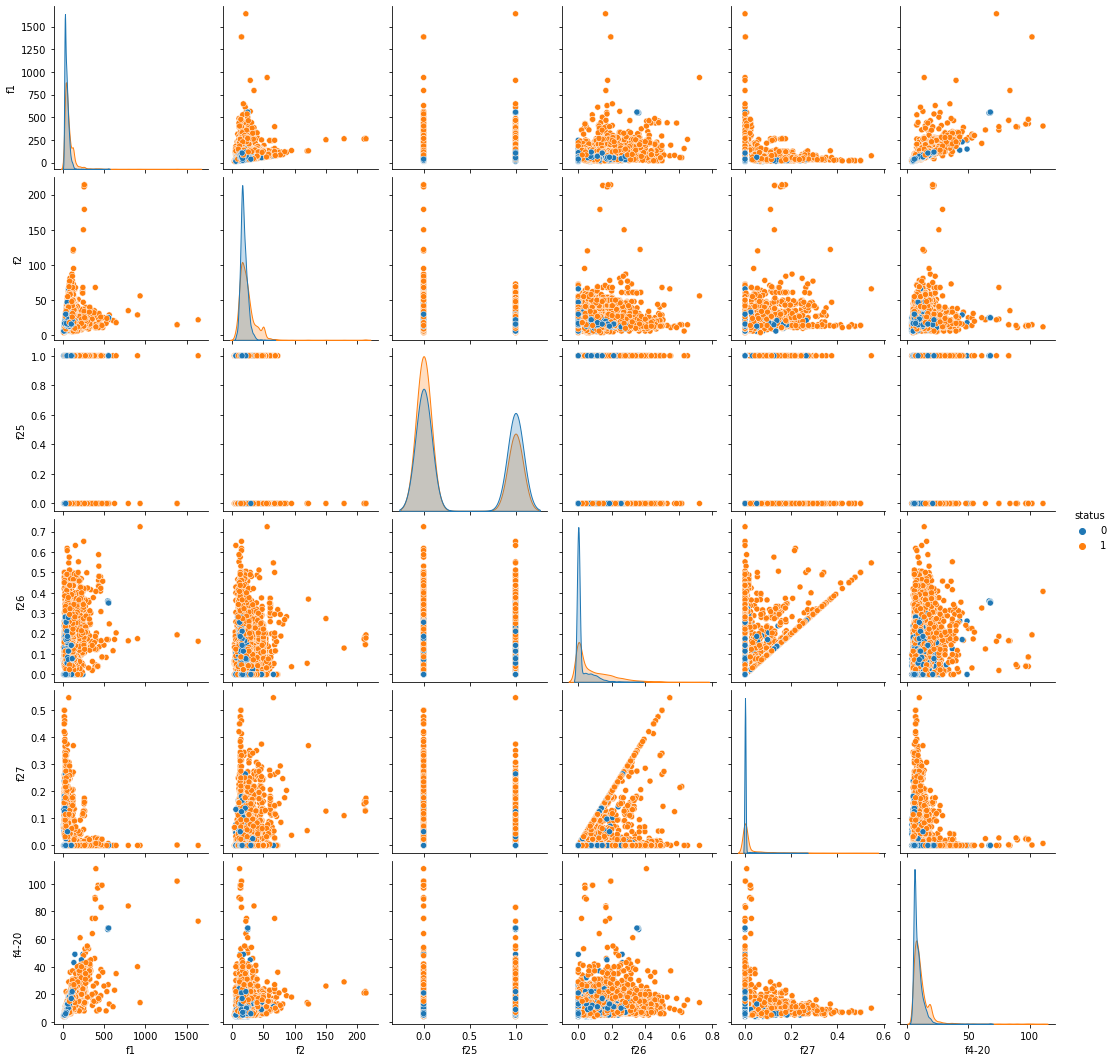

In [14]:
df_final = df
nombres_variables = ['f1', 'f2', 'f25', 'f26', 'f27','f4-20']
sns.pairplot(df_final, hue='status', vars=nombres_variables)
plt.show()

In [15]:
profile = ProfileReport(df_final, title='Reporte Status final')
profile.to_file('Reporte datos Stauts Lab1.html')

Summarize dataset:   0%|          | 0/85 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\missingno\missingno.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=fontsize)
C:\ProgramData\Anaconda3\lib\site-packages\pandas_profiling\model\summary.py:194: UserWarning: There was an attempt to generate the bar missing values diagrams, but this failed.
    To hide this warning, disable the calculation
    (using `df.profile_report(missing_diagrams={"bar": False}`)
    If this is problematic for your use case, please report this as an issue:
    https://github.com/pandas-profiling/pandas-profiling/issues
    (include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (72).')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Selección de Características 

In [16]:
new_df = df_final[['f1', 'f2', 'f4-20', 'f25', 'f26', 'f27', 'status']].copy()

In [17]:
new_df.drop_duplicates()

,f1,f2,f4-20,f25,f26,f27,status
0,37,19,7,0,0.000000,0.000000,0
1,77,23,7,0,0.220779,0.000000,1
2,126,50,19,1,0.150794,0.000000,1
3,18,11,5,0,0.000000,0.000000,0
4,55,15,10,0,0.000000,0.000000,0
...,...,...,...,...,...,...,...
11423,85,15,16,0,0.047059,0.000000,1
11424,62,15,13,0,0.000000,0.000000,0
11426,84,18,15,0,0.023810,0.000000,1
11427,105,16,17,1,0.142857,0.000000,0


### Parte 2 – Implementación del modelo 

#### Separación de datos e Implementacion del Modelo

In [18]:
target = new_df['status']
feature_matrix = new_df.drop(['status'], axis=1)

print('Final features:', feature_matrix.columns)

Final features: Index(['f1', 'f2', 'f4-20', 'f25', 'f26', 'f27'], dtype='object')


In [19]:
feature_matrix.head()

,f1,f2,f4-20,f25,f26,f27
0,37,19,7,0,0.000000,0.0
1,77,23,7,0,0.220779,0.0
2,126,50,19,1,0.150794,0.0
3,18,11,5,0,0.000000,0.0
4,55,15,10,0,0.000000,0.0


In [20]:
feature_matrix_train, feature_matrix_test, target_train, target_test = model_selection.train_test_split(feature_matrix, target, test_size=0.25, random_state=31)

In [21]:
target.to_csv("target_phishing.csv")
feature_matrix.to_csv("feature_matrix_phishing.csv")

In [22]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(feature_matrix_train, target_train)

In [23]:
print(feature_matrix_train.count())

f1       8572
f2       8572
f4-20    8572
f25      8572
f26      8572
f27      8572
dtype: int64


In [24]:
print(feature_matrix_test.count())

f1       2858
f2       2858
f4-20    2858
f25      2858
f26      2858
f27      2858
dtype: int64


In [25]:
#Metricas
target_pred = clf.predict(feature_matrix_test)
print(metrics.accuracy_score(target_test, target_pred))

0.7337298810356893


In [26]:
print('Matriz de confusion /n',metrics.confusion_matrix(target_test, target_pred))

Matriz de confusion /n [[1088  324]
 [ 437 1009]]


In [27]:
print(metrics.classification_report(target_test, target_pred, target_names=['legit', 'dga']))

              precision    recall  f1-score   support

       legit       0.71      0.77      0.74      1412
         dga       0.76      0.70      0.73      1446

    accuracy                           0.73      2858
   macro avg       0.74      0.73      0.73      2858
weighted avg       0.74      0.73      0.73      2858



### Preguntas

1. ¿Cuál es el impacto de clasificar un sitio legítimo como Pishing?
Esto hace que el sitio pierda total credibilidada y los usuarios pierdan la confianza en navegar en este. 
     
2. ¿Cuál es el impacto de clasificar un sitio de Pishing como legítimo? 
La informacion de los usuarios puede llegar a peligrar y estos pueden llegar a quedar con daños economicos, por ejemplo por estafas, emocionales, por ejemplo inquietudes acerca de quienes han tenido o pueden llegar a tener acceso a su informacion,  etc.

3. En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de pishing? 
Elegiría F1-SCORE
Consideramos que debido a que este toma en cuenta la precision y la recuperacion de la misma manera, podemos tener un buen rango y probabilidad de acertar.  

4. ¿Es necesaria la intervención de una persona humana en la decisión final de clasificación?
Considero que si, a pesar que las máquinas son bastante acertadas y concretas, la opinion de una persona puede influenciar a una mejor toma de decisiones. Sin embargo, nunca se tiene un acierto del 100%.